In [1]:
# Based on this tutorial https://www.nengo.ai/nengo-dl/examples/spiking-mnist.html

In [2]:
%matplotlib inline

import gzip
import pickle
from urllib.request import urlretrieve
import zipfile

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

from python_speech_features import fbank
import numpy as np 
import scipy.io.wavfile as wav 
import os 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.utils import shuffle

In [3]:
'''
Read data and extract spectrogram features
Split into training and testing 

'''
def read_the_csv():
    n_bands =  28 #41
    n_frames = 28 #40
    overlap = 0.5


    datasets = pd.read_csv('data.csv')
    print(len(datasets))
    
    datasets = shuffle(datasets)
    n_samples = len(datasets)

    feats = np.empty((n_samples, n_bands * n_frames))
    labels = np.empty((n_samples,), dtype=np.uint8)
    
    
    for i in range(n_samples):
        label = datasets['label'].iloc[i]
        file = datasets['filename'].iloc[i]
        labels[i] = np.uint8(label)

        rate , sig = wav.read(file)
        duration = sig.size / rate
        winlen = duration /(n_frames * (1 - overlap) + overlap)
        winstep = winlen * (1 - overlap)

        feat, energy = fbank(sig, rate, winlen, winstep, 
        nfilt=n_bands, nfft=4096, winfunc=np.hamming)

        feat = np.log(feat)
        
        feats[i] = feat[:n_frames].flatten()
    
    feats = normalize(feats, norm = 'l2', axis=1)

    np.random.seed(42)
    np.random.shuffle(feats)
    p = np.random.permutation(n_samples)
    feats, labels[p], labels[p]

    n_train_sample = int(n_samples * 0.7)

    train_set = (feats[:n_train_sample], labels[:n_train_sample])
    test_set = (feats[n_train_sample:], labels[n_train_sample:])


    return train_set, test_set

train, test = read_the_csv()

train = list(train)
test = list(test)

2000


In [4]:
'''
Transform the target labels into one-hot coding 
'''
for data in (train, test):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

In [5]:
'''
Build a nengo model with convolutional and pooling layers
'''
with nengo.Network() as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    neuron_type = nengo.LIF(amplitude=0.01)

    # we'll make all the nengo objects in the network
    # non-trainable. we could train them if we wanted, but they don't
    # add any representational power. note that this doesn't affect
    # the internal components of tensornodes, which will always be
    # trainable or non-trainable depending on the code written in
    # the tensornode.
    nengo_dl.configure_settings(trainable=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node([0] * 28 * 28)

    # add the first convolutional layer
    x = nengo_dl.tensor_layer(
        inp, tf.layers.conv2d, shape_in=(28, 28, 1), filters=32,
        kernel_size=3)

    # apply the neural nonlinearity
    x = nengo_dl.tensor_layer(x, neuron_type)

    # add another convolutional layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.conv2d, shape_in=(26, 26, 32),
        filters=64, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)

    # add a pooling layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.average_pooling2d, shape_in=(24, 24, 64),
        pool_size=2, strides=2)

    # another convolutional layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.conv2d, shape_in=(12, 12, 64),
        filters=128, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)

    # another pooling layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.average_pooling2d, shape_in=(10, 10, 128),
        pool_size=2, strides=2)

    # linear readout
    x = nengo_dl.tensor_layer(x, tf.layers.dense, units=10)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(x)
    out_p_filt = nengo.Probe(x, synapse=0.1)

In [6]:
'''
Run a simulator for 200 batch 
'''
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
| #               Optimizing graph: creating signals                  | 0:00:00

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Optimization finished in 0:00:01                                               
Construction finished in 0:00:02                                               #########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [7]:
# add the single timestep to the training data
train = {inp: train[0][:, None, :],
              out_p: train[1][:, None, :]}

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps. we're also going to reduce the number of test images, just
# to speed up this example.
n_steps = 100 #30
test = {
    inp: np.tile(test[0][:minibatch_size*2, None, :],
                 (1, n_steps, 1)),
    out_p_filt: np.tile(test[1][:minibatch_size*2, None, :],
                        (1, n_steps, 1))}

In [8]:
'''
Objective function 
'''
def objective(outputs, targets):
    return tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=outputs, labels=targets)

In [9]:
'''
Build an optimizer and a classification error 
'''
opt = tf.train.RMSPropOptimizer(learning_rate=0.001)

def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1),
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))

# Didn't understand this part 
print("error before training: %.2f%%" % sim.loss(
    test, {out_p_filt: classification_error}))

Calculation finished in 0:02:55                                                
error before training: 89.25%


In [10]:
'''
Choose to train the model from the scratch or use a pre-trained model
'''

do_training = False
if do_training:
    # run training
    sim.train(train, opt, objective={out_p: objective}, n_epochs=1000)

    # save the parameters to file
    sim.save_params("./sr_params")
else:

    # load parameters
    sim.load_params("./sr_params")

In [11]:
''' Check the error '''
print("error after training: %.2f%%" % sim.loss(
    test, {out_p_filt: classification_error}))

Calculation finished in 0:02:47                                                
error after training: 91.25%


Simulation finished in 0:01:36                                                 


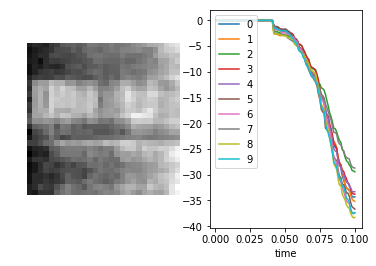

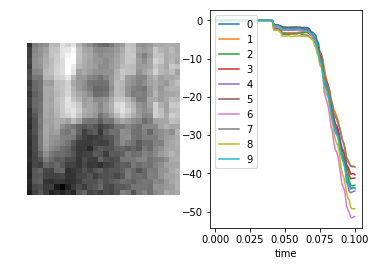

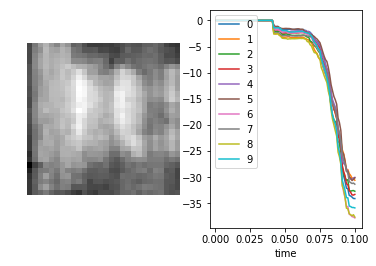

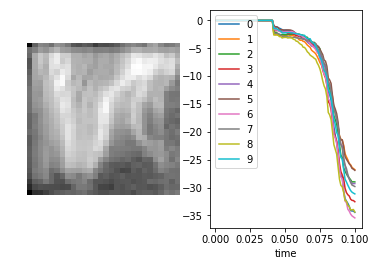

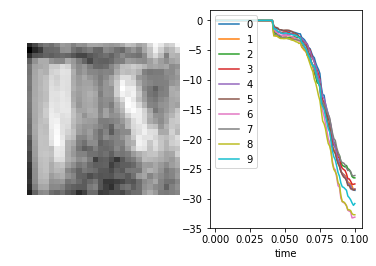

In [12]:
sim.run_steps(n_steps, data={inp: test[inp][:minibatch_size]})

for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(test[inp][i, 0], (28, 28)),
               cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(sim.trange(), sim.data[out_p_filt][i])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("time")